### Experiementation of Decoder Only Transformer for Time Series Forecasting

In [1]:
import torch
import torch.optim as optim
import os
from argparse import Namespace
from stock_transformer_trainer import StockGPTTrainer
import pandas as pd
from data import PdTorchDataset
import torch.nn as nn
import pandas as pd
from time_series_transformer import TimeSeriesGPT
from stocks import StockDatasetGPT
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

### Train
A 5 layer decoder only transformer with 20 day sequence (sequence_length 21)

In [2]:
args = Namespace(dataset_csv="sector_etf.csv",
                 model_state_file="transform_ts_gpt_model.pth",
                 save_dir="model_storage/stock/",
                 reload_from_files=True,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=1e-3,
                 batch_size=64,
                 num_epochs=100,
                 num_encoder_layer=5,
                 num_decoder_layer=5,
                 num_attn_heads=4,
                 model_size=64,
                 dropout=0.2,
                 early_stopping_criteria=100,
                 sequence_length=21,
                 catch_keyboard_interrupt=True)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# create dataset
src_cols = ['XLF', 'XLB', 'XLE', 'XLK']

df = pd.read_csv(args.dataset_csv)
dataset = StockDatasetGPT(df,
                          sequence_length=args.sequence_length,
                          src_cols=src_cols)

# Set seed for reproducibility
StockGPTTrainer.set_seed_everywhere(args.seed, args.cuda)

# handle dirs
StockGPTTrainer.handle_dirs(args.save_dir)

model = TimeSeriesGPT(input_size=len(src_cols),
                      model_size=args.model_size,
                      output_size=len(src_cols),
                      num_decoder=args.num_decoder_layer,
                      decoder_dropout=args.dropout,
                      decoder_num_attn_heads=args.num_attn_heads)

optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

trainer = StockGPTTrainer(model, optimizer, scheduler)
train_state = trainer.train(dataset=dataset, args=args)
print("training finished: train_loss = ", train_state['train_loss'])

# save the last model
torch.save(model.state_dict(), args.model_state_file)

Expanded filepaths: 
	model_storage/stock/transform_ts_gpt_model.pth
Using CUDA: True


C:\Users\davefang\.conda\envs\textmining\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

training finished: train_loss =  [0.04861937505125567, 0.012247872390392898, 0.008350489316913099, 0.006590499778858562, 0.005529616264275451, 0.004793888862258283, 0.004351536395784089, 0.003932587350246269, 0.0035021218363249645, 0.0032263902198199344, 0.0031035353490353927, 0.0028695855728364077, 0.0026021297157242675, 0.002492884718947976, 0.0022802881886372747, 0.002201594793629172, 0.0021180577755001355, 0.002016396973741011, 0.0018216625439758966, 0.0017806999689049046, 0.001698299297604008, 0.0017081743487548356, 0.0016858929049466615, 0.001642340336980271, 0.001698668782963701, 0.0016476933766777317, 0.0016776820141957073, 0.0016691133049249217, 0.001714265711295108, 0.0017401421159181905, 0.0017192727983996704, 0.0017607634519294336, 0.0017980602299929528, 0.001773349011141429, 0.0018183883444905498, 0.0018346456935683238, 0.00185904820598122, 0.0019574690276109013, 0.0019499803032807042, 0.0019574923832239455, 0.0020220550721970158, 0.0020457929661632447, 0.00207205269269753

### Loss plot
As teacher forcing is gradually removed as number of epochs, the fit start to get worse.

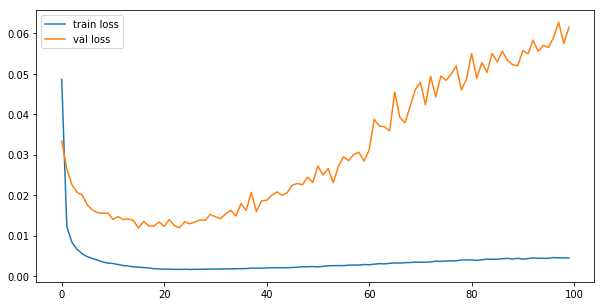

In [9]:
plt.figure(figsize=(10,5))
plt.plot(train_state['train_loss'], label='train loss')
plt.plot(train_state['val_loss'], label='val loss')
plt.legend(loc="upper left")

### Forecasts and Plots

In [4]:
model.load_state_dict(torch.load(args.model_state_file))
model.eval()

TimeSeriesGPT(
  (target_fc): Linear(in_features=4, out_features=64, bias=True)
  (target_pos): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (stacked_decoders): ModuleList(
    (0): Decoder(
      (attn_masked): MultiHeadAttention(
        (attn_heads): ModuleList(
          (0): ScaleDotProductAttention(
            (query_fc): Linear(in_features=64, out_features=16, bias=True)
            (key_fc): Linear(in_features=64, out_features=16, bias=True)
            (value_fc): Linear(in_features=64, out_features=16, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (1): ScaleDotProductAttention(
            (query_fc): Linear(in_features=64, out_features=16, bias=True)
            (key_fc): Linear(in_features=64, out_features=16, bias=True)
            (value_fc): Linear(in_features=64, out_features=16, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (2): ScaleDotProductAttention(
         

In [5]:
def forecast_and_plot(model, dataset, split, src_cols, args):
    dataset.set_split(split)
    x_source = np.zeros((len(dataset)+args.sequence_length, len(src_cols)))
    pred = np.zeros((len(dataset)+1, len(src_cols)))
    # generate input one at a time and no shuffle to keep the time order
    batch_generator = dataset.generate_batches(dataset, batch_size=1, shuffle=False, device=args.device)
    for batch_index, batch_dict in enumerate(batch_generator):
        y_input = batch_dict['y_input']
        # forecast
        x_out = model(sequence=y_input, teacher_forcing_prob_threshold=0.0)
        # input sequence is of length sequence_length - 1
        x_source[batch_index:batch_index+args.sequence_length-1, :] = y_input[:,:-1,:].detach().cpu().numpy()
        pred[batch_index+args.sequence_length:batch_index+batch_index+args.sequence_length+1, :] = \
            x_out[:,-1,:].detach().cpu().numpy()
    
    x_source_transformed = dataset.inverse_transform(src_cols, x_source)
    pred_transformed = dataset.inverse_transform(src_cols, pred)

    # fill np.nan for plotting purpose
    x_source[-args.sequence_length-1:, :] = np.nan
    pred[:args.sequence_length, :] = np.nan
    x_source_transformed[-args.sequence_length-1:, :] = np.nan
    pred_transformed[:args.sequence_length, :] = np.nan
    
    for i in range(len(src_cols)):
        plt.figure(figsize=(10, 5))
        plt.title(src_cols[i])
        plt.plot(x_source_transformed[:, i], label='history')
        plt.plot(pred_transformed[:, i], label='prediction')
        plt.legend(loc="upper left")

    return x_source_transformed, pred_transformed, x_source, pred


From the charts, <b>the forecasts look more like parallel shift to the right which is not very useful.</b> Also the starting forecasts are quite off from the historical time series. Maybe there are something wrong in the model implementation. 

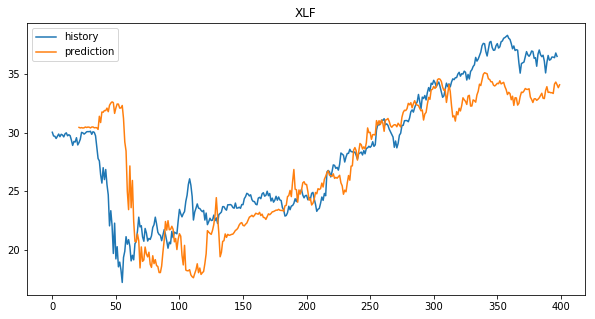

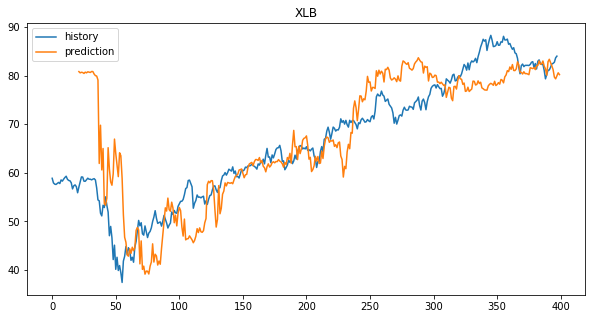

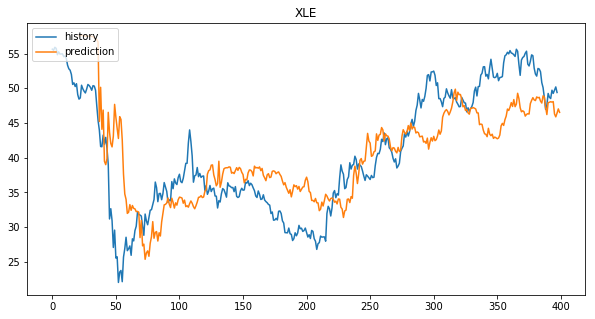

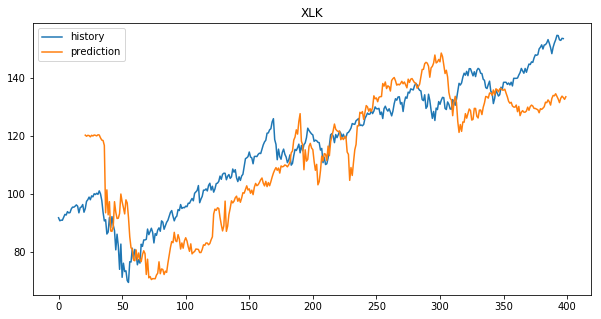

In [6]:
x_source_test, pred_test, _, _ = forecast_and_plot(model, dataset, 'test', src_cols, args)

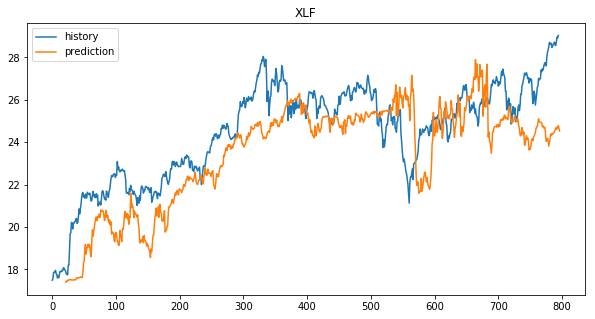

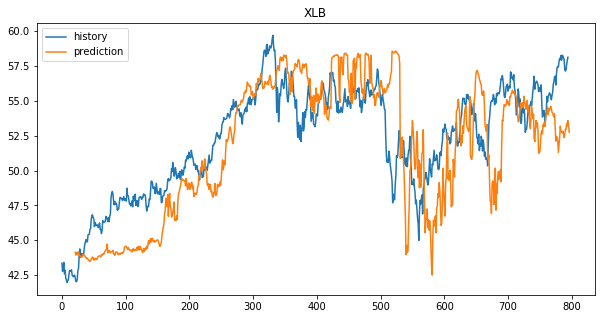

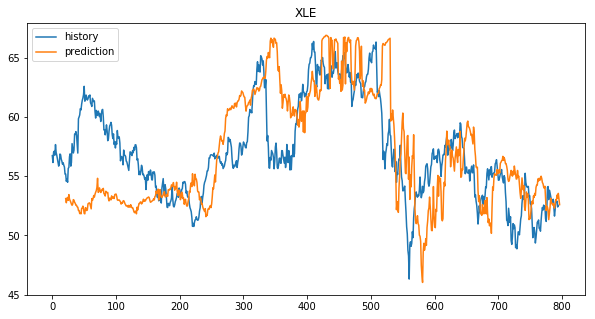

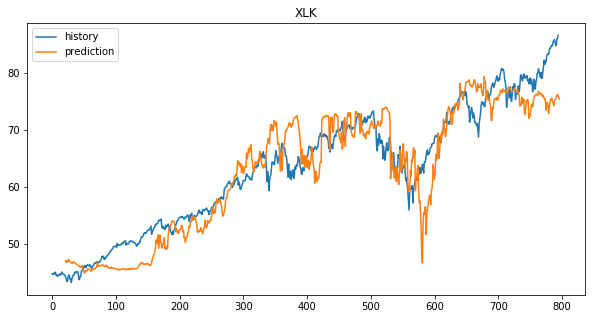

In [7]:
x_source_val, pred_val, _, _ = forecast_and_plot(model, dataset, 'val', src_cols, args)

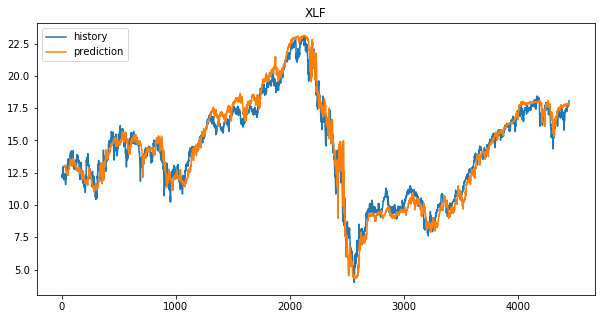

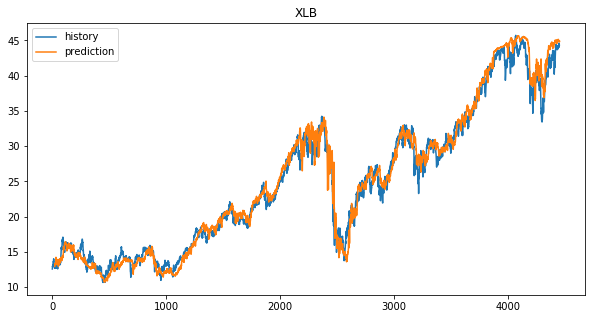

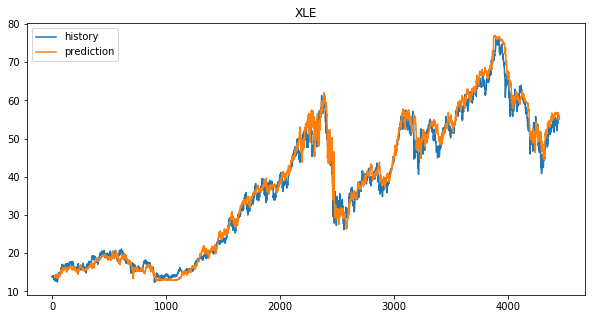

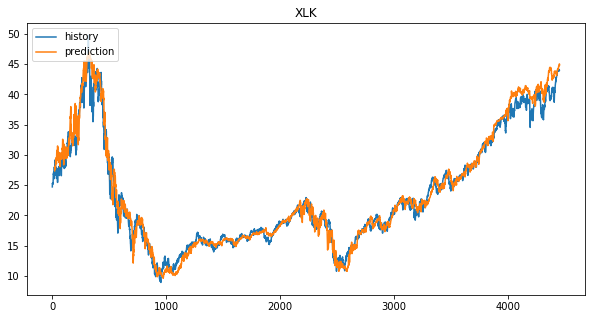

In [8]:
x_source_train, pred_train, _, _ = forecast_and_plot(model, dataset, 'train', src_cols, args)